#### The purpose of this EDA notebook is the following:
- Better understand the nature of the relationship between the independent variables
- Create an initial model with reasonable economic assumptions that may be dropped in later versions
- Explore methods of imputation for missing variables to provide more data samples
- Avoid linear combinations that might be more difficult to spot in the Bayesian Modeling process
- Establish a reasonable measure of variable importance, which along with correlation plots may inform initial hierarchies
- Create visualizations of poor quality data and also establish probability distributions for the likelihood function

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from rfpimp import *
from rfpimp import plot_corr_heatmap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import category_encoders as ce

#### In an effort to generalize for future EDA, 'df' makes it easier to debug

In [142]:
df = pd.read_csv('C:/Users/norri/Desktop/all_ab_data.csv')
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4393 entries, 0 to 4392
Columns: 123 entries, % Dollar Sales by Merch Any Display to Weighted Average Base Price Per Unit
dtypes: float64(107), int64(6), object(10)
memory usage: 4.1+ MB


### The info function above tells us we have three data types and counts of each. The next section will explore those variables in groups.

In [143]:
df = df.drop(['CONCAT', 'Brewer Value'], axis=1)
segment = [var for var in df.columns if df[var].dtype == 'O']
print('There are {} categorical variables\n'.format(len(segment)))
print('The categorical variables are :\n\n', segment)
print(df[segment].isnull().sum() / len(df))
df_cat = df.select_dtypes(include=object)
df_cat.info()
df_cat.describe()


# I like this visualization but it needs some tweaking or replacement
# note: write a function because this repetitive plotting could be done in a few lines
# for col in segment:
#     sns.boxplot(y=df_cat.nunique().astype('int32'), x=col, data=df_cat)
#     plt.show()

There are 8 categorical variables

The categorical variables are :

 ['Brand Family Value', 'Brand Value', 'Category Value', 'Geography', 'Product', 'Segment Value', 'Time', 'Type Value']
Brand Family Value    0.208969
Brand Value           0.529706
Category Value        0.016390
Geography             0.000000
Product               0.000000
Segment Value         0.140451
Time                  0.000000
Type Value            0.298657
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4393 entries, 0 to 4392
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Brand Family Value  3475 non-null   object
 1   Brand Value         2066 non-null   object
 2   Category Value      4321 non-null   object
 3   Geography           4393 non-null   object
 4   Product             4393 non-null   object
 5   Segment Value       3776 non-null   object
 6   Time                4393 non-null   object
 7   Type V

,Brand Family Value,Brand Value,Category Value,Geography,Product,Segment Value,Time,Type Value
count,3475,2066,4321,4393,4393,3776,4393,3081
unique,41,31,3,15,72,6,6,8
top,MICHELOB ULTRA FAMILY,BUD LIGHT,BEER,AWG Corp-SRMA - Food,BUD LIGHT,CRAFT/IMPORT,Week Ending 01-02-22,LIGHT
freq,332,90,4248,359,90,969,740,928


In [144]:
df = df.drop(
    ['F81', 'Product Development Index', 'Sum of Dollar Sales Checkout Display',
     'Sum of Dollar Sales Outside Display', 'Sum of Dollar Sales Signage and Feature',
     'Sum of Dollar Sales Signage, Feature and Display'], axis=1)
integer = [var for var in df.columns if df[var].dtype == 'int64']
print('There are {} integer variables\n'.format(len(integer)))
print('The integer variables are :\n\n', integer)
print(df[integer].isnull().sum())
df_int = df.select_dtypes(include=int)
if len(df_int.columns) > 0.0:
    df_int.info()
    df_int.describe()


There are 0 integer variables

The integer variables are :

 []
Series([], dtype: float64)


In [146]:
df = df.drop(
    ['Unit Share of SubCategory', 'Dollar Share of SubCategory',
     'Incremental Dollars', 'Incremental Dollars % Change vs YA',
     'Incremental Units', 'Incremental Units % Change vs YA',
     '% Increase in Dollars by Merch Any Special Pack',
     '% Increase in Dollars by Merch Special Pack Only',
     '% Increase in Units by Merch',
     '% Increase in Units by Merch Any Special Pack',
     '% Increase in Units by Merch Special Pack Only',
     '% Incremental Units by Merch Any Special Pack',
     '% Incremental Units by Merch Special Pack Only'], axis=1)
fp = [var for var in df.columns if df[var].dtype == 'float64']
print('There are {} float variables\n'.format(len(fp)))
print('The float variables are :\n\n', fp)
fp_na = df[fp].isnull().sum() / len(df) * 100
print(fp_na[fp_na > 10])
fp_zero = df[fp].sum()
print(fp_zero[fp_zero == 0.0])

There are 94 float variables

The float variables are :

 ['% Dollar Sales by Merch Any Display', '% Dollar Sales by Merch Any Feature', '% Dollar Sales by Merch Any Merch', '% Dollar Sales by Merch Any Price Reduction', '% Increase in Dollars by Merch Advertised Frequent Shopper', '% Increase in Dollars by Merch Any Display', '% Increase in Dollars by Merch Any Feature', '% Increase in Dollars by Merch Any Merch', '% Increase in Dollars by Merch Any Price Reduction', '% Increase in Dollars by Merch Display Only', '% Increase in Dollars by Merch Feature and Display', '% Increase in Dollars by Merch Feature and/or Display', '% Increase in Dollars by Merch Feature Only', '% Increase in Dollars by Merch Price Reductions Only', '% Increase in Units by Merch Advertised Frequent Shopper', '% Increase in Units by Merch Any Display', '% Increase in Units by Merch Any Feature', '% Increase in Units by Merch Any Merch', '% Increase in Units by Merch Any Price Reduction', '% Increase in Units by 

In [150]:

df_fp = df.select_dtypes('float')
df_fp.describe()
df_num = df_fp

### Clearly the float variables contain all the missing data in the dataset. In
### cases like this, dropping the missing values are a trade-off to consider
### against dropping an entire column and losing its input into the model

ValueError: num must be 1 <= num <= 16, not 17

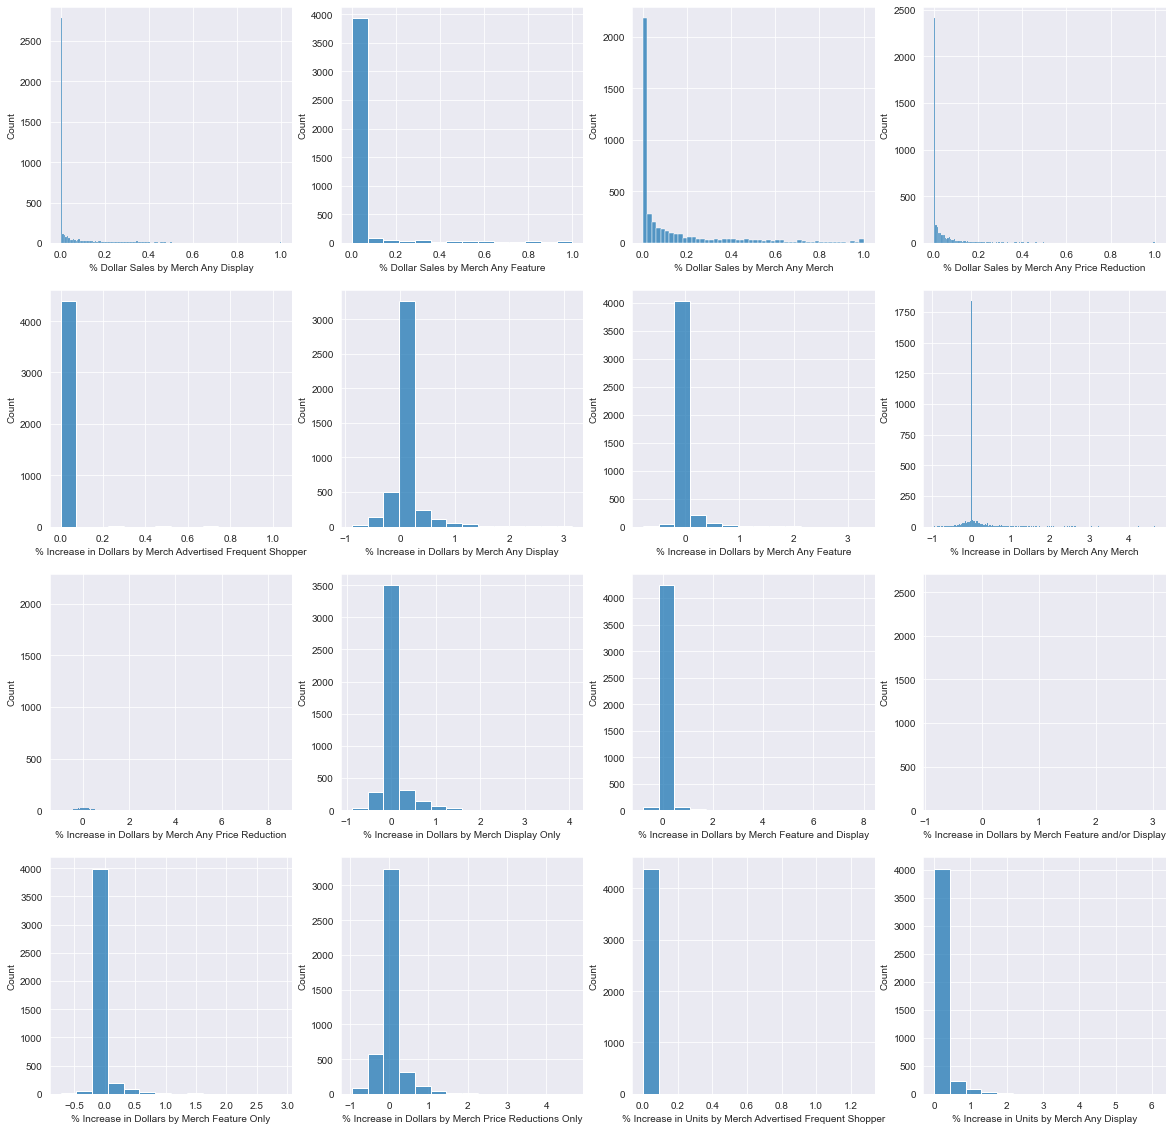

In [148]:
# this section should come later; for larger datasets takes too long to run
# with too little return in information
cols = 4
rows = 4
num_cols = df_num.select_dtypes(exclude='object').columns
fig = plt.figure(figsize=(cols * 5, rows * 5))
for i, col in enumerate(num_cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    sns.histplot(x=df[col], ax=ax)
fig.tight_layout()
plt.show()

In [151]:
# these visualizations provide some clue as to how to model the large number
# of variables and to examine their relationships
corr = df_num.corr(method="pearson")
corr.style.background_gradient(cmap="coolwarm").set_precision(2)

C:\Users\norri\AppData\Local\Temp\ipykernel_1860\1793195246.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap="coolwarm").set_precision(2)
C:\Users\norri\.conda\envs\Attribution_EDA\lib\site-packages\pandas\io\formats\style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\norri\.conda\envs\Attribution_EDA\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


##### Imputation of missing values is too unreliable to base the rest of the
##### model on. Later tests will tell if there is any bias present. This is when
##### the most standout variables should be chosen for the model

In [165]:
corr_imp = corr[abs(corr['Sum of Dollar Sales']) > .5]
corr_imp = corr_imp[['Sum of Dollar Sales']]
print(corr_imp)

                                              Sum of Dollar Sales
Avg Weekly Items per Store Selling                       0.546726
Avg Weekly Units per Store Selling                       0.700336
Base Dollar Sales                                        0.998855
Base Unit Sales                                          0.942988
Dollar Sales                                             0.999995
Dollar Sales per Pt of Distribution                      0.943502
Dollar Sales per Pt of Distribution Year Ago             0.930899
Dollar Share of Category                                 0.510543
Number of Stores Selling                                 0.508714
Sum of Base Dollar Sales                                 0.998863
Sum of Dollar Sales                                      1.000000
Sum of Dollar Sales Any Display                          0.777842
Sum of Dollar Sales Any Merch                            0.773831
Sum of Dollar Sales Any Price Reduction                  0.579765
Sum of Dol

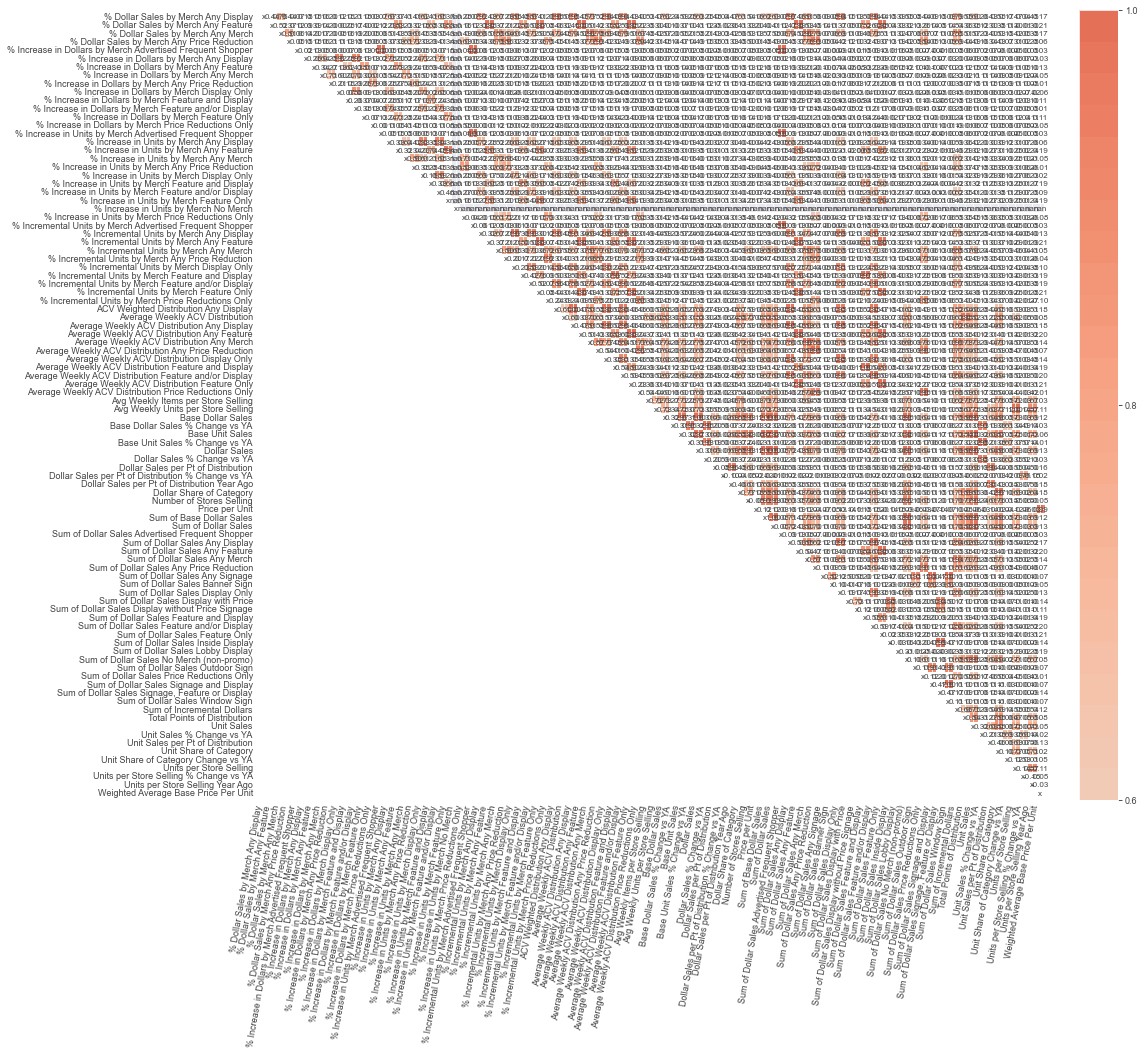

In [153]:
# this is just another visualization of correlation that I like, I may switch it with others
# viz = plot_corr_heatmap(df_num, figsize=(16,17))
# viz.view()

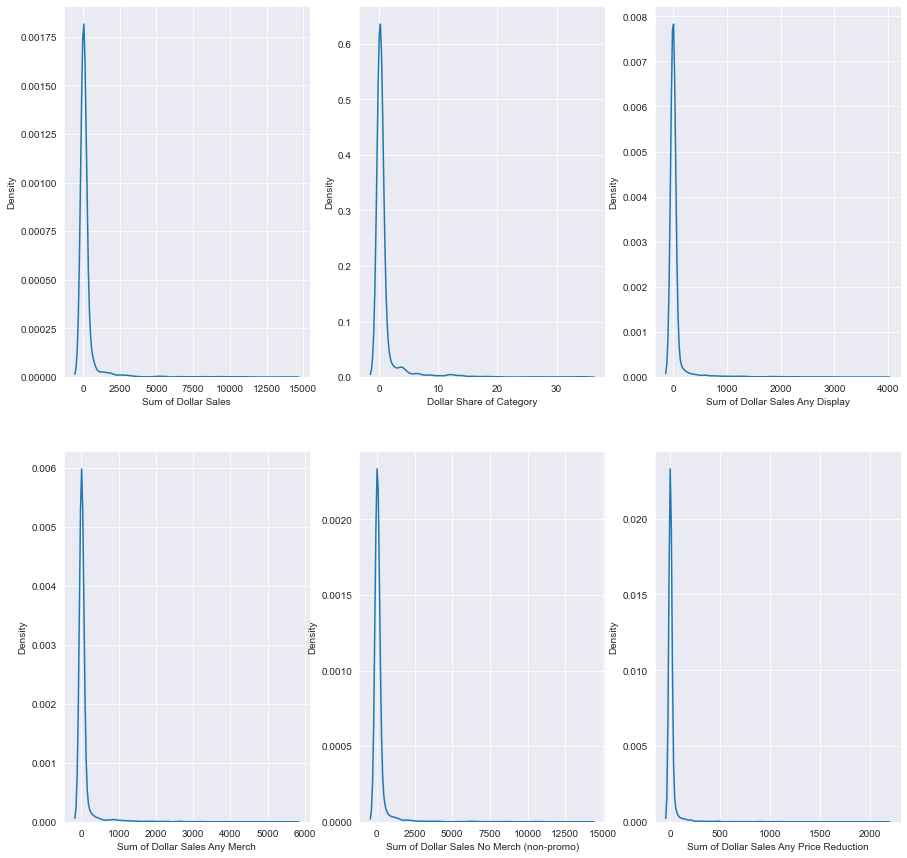

In [166]:
figure, axes = plt.subplots(2, 3, figsize=(15, 15))
sns.kdeplot(ax=axes[0, 0], x='Sum of Dollar Sales', data=df_num)
sns.kdeplot(ax=axes[0, 1], x='Dollar Share of Category', data=df_num)
sns.kdeplot(ax=axes[0, 2], x='Sum of Dollar Sales Any Display', data=df_num)
sns.kdeplot(ax=axes[1, 0], x='Sum of Dollar Sales Any Merch', data=df_num)
sns.kdeplot(ax=axes[1, 1], x='Sum of Dollar Sales No Merch (non-promo)', data=df_num)
sns.kdeplot(ax=axes[1, 2], x='Sum of Dollar Sales Any Price Reduction', data=df_num)
plt.show()

### These kde plots will a primary tool in determining the likelihood
### distributions and giving information on the prior

In [265]:
df_all = df_num.dropna().astype(dtype='int32')

features = ['Sum of Dollar Sales Any Merch', 'Dollar Share of Category',
            'Sum of Dollar Sales Any Display',
            'Sum of Dollar Sales No Merch (non-promo)',
            'Sum of Dollar Sales Any Price Reduction']
target = 'Sum of Dollar Sales'
df_all = df_all[features + [target]]
df_train, df_test = train_test_split(df_all, test_size=0.15)

X_train, y_train = df_train.drop('Sum of Dollar Sales', axis=1), df_train['Sum of Dollar Sales']
X_test, y_test = df_test.drop('Sum of Dollar Sales', axis=1), df_test['Sum of Dollar Sales']

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=1.0, min_samples_leaf=10, n_jobs=-1,
                       oob_score=True)

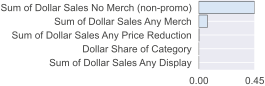

In [266]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0, warm_start=False)

I = importances(rf, X_test, y_test)
plot_importances(I)

### This importance plot from a RandomForestClassifier is one of the key
### ways we'll understand which variables are the most important

#### With an array of all the variables, I could make an importance plot
#### for everything but the categorical variables, but I would have to change
#### the dependent variable each time. Remember that we dropped missing values
#### instead of dropping columns, which we could do with a column that did not
#### make an impression on the correlation plot or importance plot

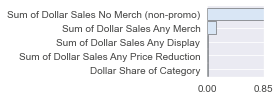

In [267]:
I = pd.DataFrame()

I['Feature'] = X_train.columns
I['Importance'] = rf.feature_importances_
I = I.sort_values('Importance', ascending=False)
I = I.set_index('Feature')
viz = plot_importances(I)

#### Our categorical variables shouldn't be forgotten; just alter the threshold
#### down from 250 if the axis titles start to look messy

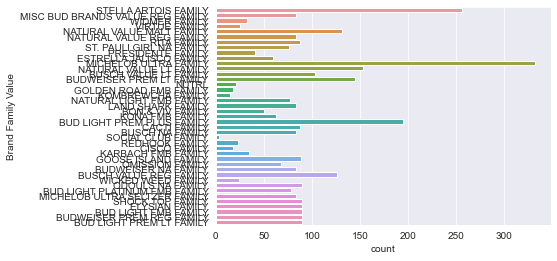

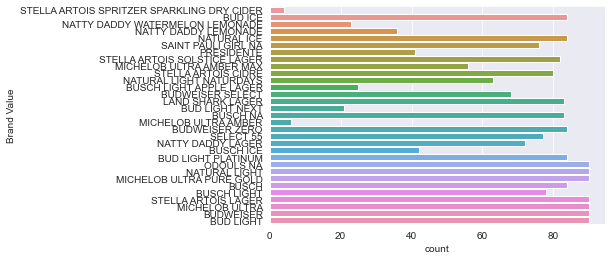

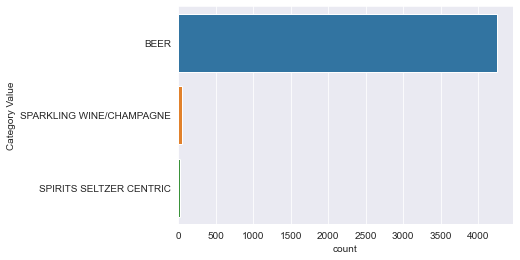

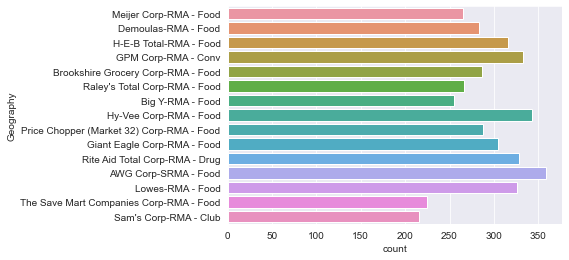

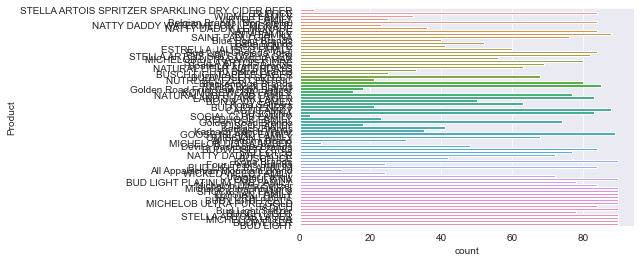

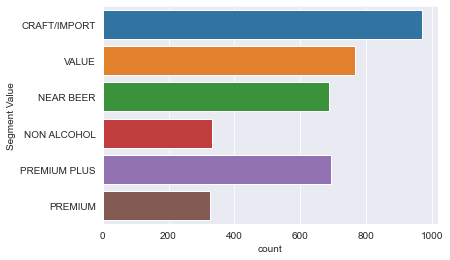

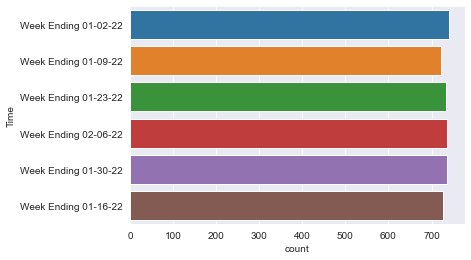

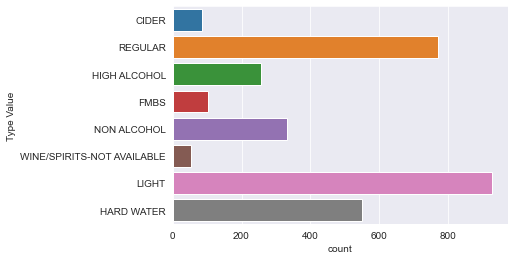

In [177]:
# for col in df.select_dtypes(include='object'):
#     if df[col].nunique() <= 250:
#         sns.countplot(y=col, data=df)
#         plt.show()

In [264]:
x = df_all.loc[:, features].values
y = df_all.loc[:, ['Sum of Dollar Sales']].values
# x = StandardScaler().fit_transform(x)
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

print(pca.components_)
print(pca.explained_variance_)
principalDf = pd.DataFrame(data = principalComponents
                           , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_all['Sum of Dollar Sales']], axis = 1)

[[ 0.39540786  0.39540786  0.24897145  0.37751357  0.39540786  0.39540786
   0.27011822  0.31167833]
 [ 0.15604939  0.15604939 -0.73700324  0.05406722  0.15604939  0.15604939
  -0.55728069  0.21432578]]
[6.22123844 0.75084786]


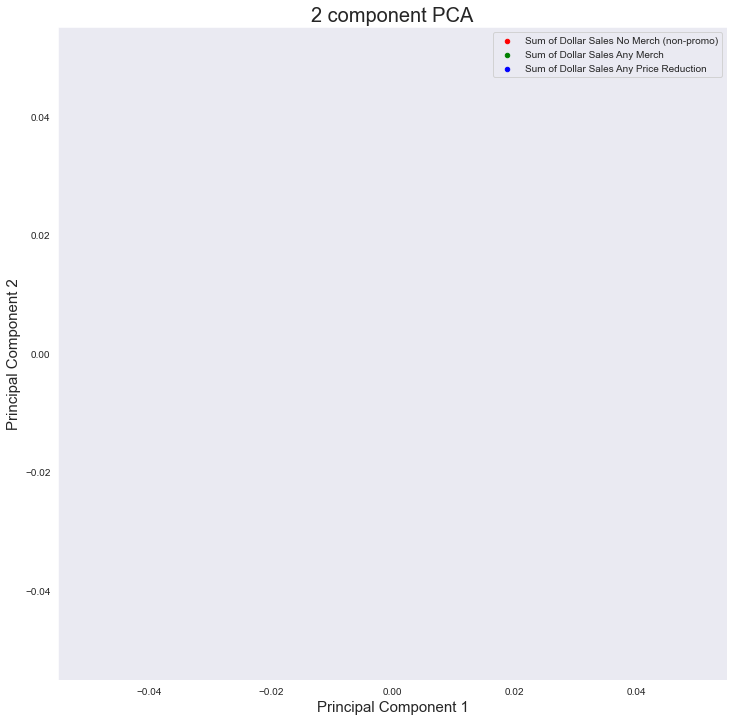

In [260]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Sum of Dollar Sales No Merch (non-promo)',
           'Sum of Dollar Sales Any Merch',
           'Sum of Dollar Sales Any Price Reduction']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Sum of Dollar Sales'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c=color
               , s = 20)
ax.legend(targets)
ax.grid()